In [2]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import scipy
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv(r'input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


<Axes: ylabel='type'>

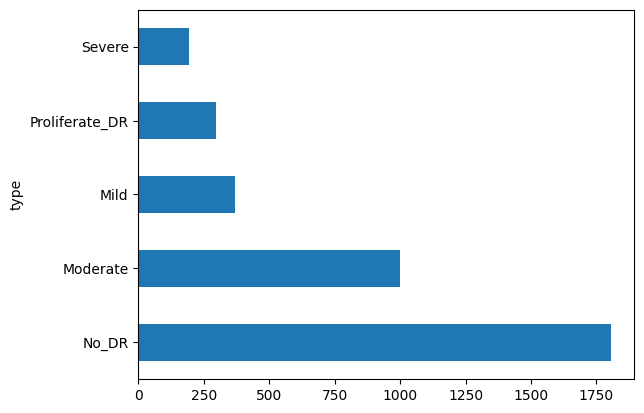

In [5]:
df['type'].value_counts().plot(kind='barh')

In [6]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print("For Training Dataset :")
print(train['type'].value_counts(), '\n')
print("For Testing Dataset :")
print(test['type'].value_counts(), '\n')
print("For Validation Dataset :")
print(val['type'].value_counts(), '\n')

For Training Dataset :
type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

For Testing Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

For Validation Dataset :
type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [7]:
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

In [8]:
src_dir = r'input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)
 
for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

In [9]:
train_path = 'train'
val_path = 'val'
test_path = 'test'
#Default Batch - 32
train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)

Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [10]:
model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="same", input_shape=(224,224,3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(16, (3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(32, (3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(64, (3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

model.summary()

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(train_batches,
                    epochs=15,
                    validation_data=val_batches,
                    callbacks=callbacks)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 8)       224       
                                                                 
 batch_normalization_4 (Bat  (None, 224, 224, 8)       32        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 112, 112, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 16)      1168      
                                                                 
 batch_normalization_5 (Bat  (None, 112, 112, 16)      64        
 chNormalization)                                                
                                                      

KeyboardInterrupt: 

In [11]:
base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

# Unfreeze some layers in base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['acc'])

model.summary()

# Training
history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches,
                    callbacks=[reduce_lr, early_stopping])
model.save('64x3-CNN4.model')

16556032/58889256 [=======>......................] - ETA: 4:19

KeyboardInterrupt: 

In [45]:
model.save('64x3-CNN.model')
#model.save("model.h5")


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


INFO:tensorflow:Assets written to: 64x3-CNN.model\assets


In [46]:
loss, acc = model.evaluate(test_batches, verbose=1)
print("Loss: ", loss)
print("Accuracy: ", acc)

18/18 [==============================] - 4s 212ms/step - loss: 0.1617 - acc: 0.9545
Loss:  0.1617060899734497
Accuracy:  0.9545454382896423


In [2]:
from sklearn.metrics import roc_curve, auc

In [62]:
def predict_class(path):
    # Read and preprocess the image
    img = cv2.imread(path)
    RGBImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    RGBImg = cv2.resize(RGBImg, (224, 224))
    plt.imshow(RGBImg)
    plt.show()

    image = np.array(RGBImg) / 255.0  # Normalize the image

    # Load the model
    new_model = tf.keras.models.load_model("64x3-CNN2.model")

    # Make a prediction
    predict = new_model.predict(np.array([image]))

    # Get the predicted class
    per = np.argmax(predict, axis=1)

    # Interpret the prediction
    if per == 1:
        result = 'Diabetic Retinopathy Not Detected'
    else:
        result = 'Diabetic Retinopathy Detected'

    # Return the result and the probabilities
    return result, predict[0].tolist()

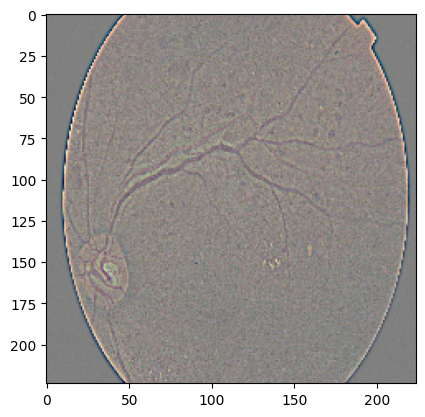

1/1 [==============================] - 0s 290ms/step


('Diabetic Retinopathy Detected', [0.999439537525177, 0.0005604489706456661])

In [63]:
predict_class('input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Severe/1b495ac025b7.png')

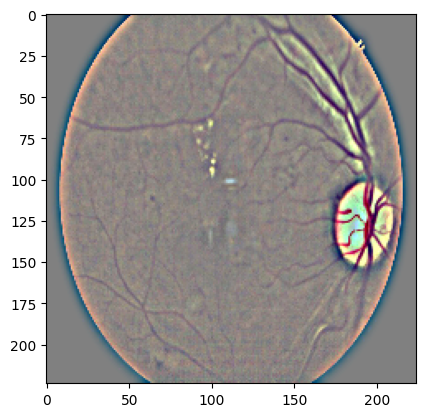

1/1 [==============================] - 0s 234ms/step


('Diabetic Retinopathy Detected', [0.8123250603675842, 0.18767492473125458])

In [64]:
predict_class('input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Mild/1d11794057ff.png')

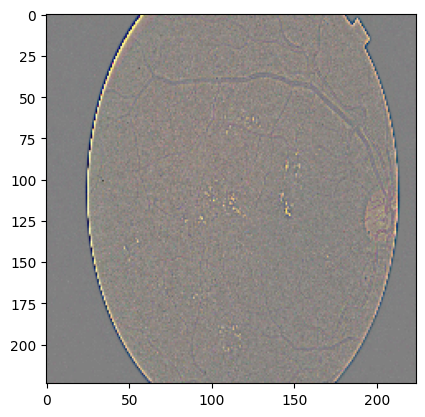

1/1 [==============================] - 0s 229ms/step


('Diabetic Retinopathy Detected', [0.9999971389770508, 2.85517489828635e-06])

In [65]:
predict_class('input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Moderate/000c1434d8d7.png')

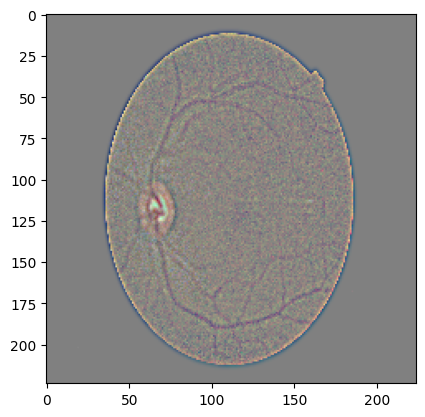

1/1 [==============================] - 0s 201ms/step


('Diabetic Retinopathy Not Detected', [2.5956826021911183e-08, 1.0])

In [66]:
predict_class('input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR/005b95c28852.png')

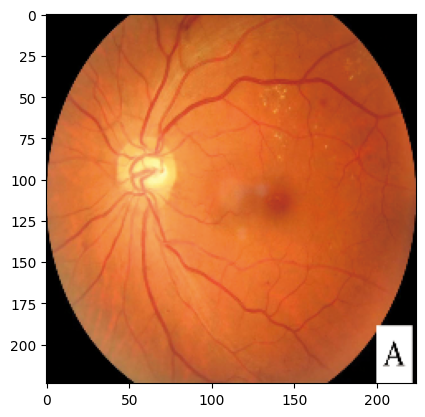

1/1 [==============================] - 0s 314ms/step


('Diabetic Retinopathy Detected', [0.5327767729759216, 0.467223197221756])

In [70]:
predict_class('Fundus_-_diabetic_retinopathy.png')

In [68]:
# Load the model using tf.saved_model.load
model = tf.saved_model.load("64x3-CNN2.model")

# Print the signatures of the model
print(list(model.signatures.keys()))

# Inspect the default signature
print(model.signatures['serving_default'])


['serving_default']
ConcreteFunction signature_wrapper(*, conv2d_input)
  Args:
    conv2d_input: float32 Tensor, shape=(None, 224, 224, 3)
  Returns:
    {'dense_1': <1>}
      <1>: float32 Tensor, shape=(None, 2)


18/18 [==============================] - 3s 150ms/step


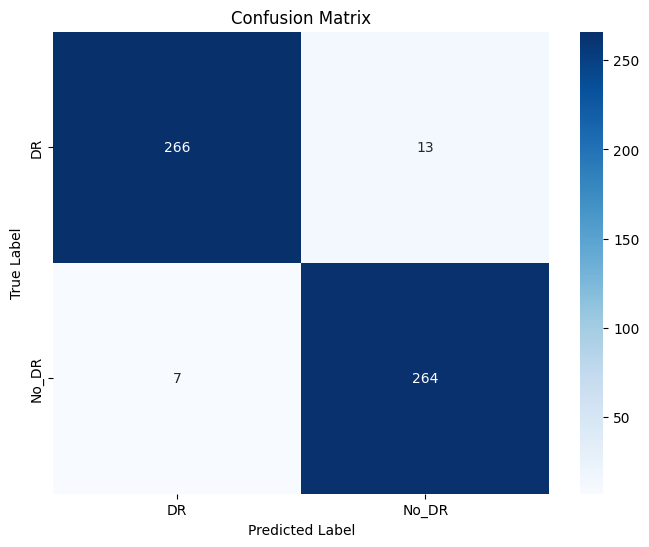

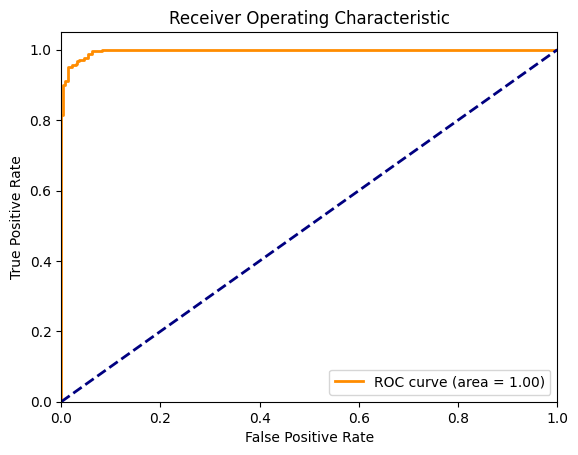

In [24]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras.models import load_model

# Load your CNN model (assuming it's saved as 'model.h5')
model = load_model("64x3-CNN2.model")

# Make predictions
y_pred_prob = model.predict(test_batches)
y_true = test_batches.classes
y_pred = np.argmax(y_pred_prob, axis=1)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_batches.class_indices.keys())  # Get class names
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [25]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Specificity = TN / (TN + FP)
# Extract TN and FP from the confusion matrix
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

specificity = tn / (tn + fp)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Specificity: {specificity}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F-Measure: {f1}')

Accuracy: 0.9636363636363636
Specificity: 0.953405017921147
Recall: 0.9636363636363636
Precision: 0.9638686223523769
F-Measure: 0.9636378061798564
